# 09차시: 이동평균을 이용한 금융 시계열 추세 분석

## 학습 목표
- 단순 이동평균(SMA)과 지수 이동평균(EMA) 개념 이해
- 단기, 중기, 장기 이동평균선 시각화
- 골든크로스 / 데드크로스 개념 이해 및 시각화

## 학습 내용
1. 이동평균의 개념
2. 단순 이동평균(SMA) 계산
3. 이동평균선 시각화
4. 지수 이동평균(EMA)
5. 골든크로스 / 데드크로스

In [1]:
# 라이브러리 설치
!pip install pykrx -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 11.0 MB/s eta 0:00:00


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Korean font ready: NanumGothic


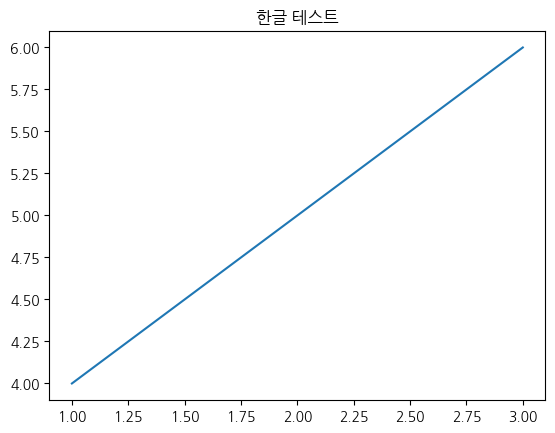

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

def setup_korean_font_colab(verbose=True):
    """Colab 한글 폰트 설정"""
    import os
    import matplotlib as mpl
    import matplotlib.font_manager as fm
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
    if not os.path.exists(font_path):
        !apt-get update -qq
        !apt-get install -y fonts-nanum -qq
        pass
    try:
        fm.fontManager.addfont(font_path)
    except:
        pass
    font_name = fm.FontProperties(fname=font_path).get_name()
    mpl.rcParams["font.family"] = font_name
    mpl.rcParams["axes.unicode_minus"] = False
    if verbose:
        print(f"Korean font ready: {font_name}")
    return font_name

setup_korean_font_colab()

# 테스트
plt.plot([1, 2, 3], [4, 5, 6])
plt.title('한글 테스트')
plt.show()

---
## 1. 이동평균(Moving Average)의 개념

### 이동평균이란?
- 일정 기간 동안의 가격 평균을 계산하여 추세를 파악하는 기법
- 가격 변동의 노이즈를 제거하고 전반적인 방향성을 파악
- 가장 널리 사용되는 기술적 분석 도구

### 이동평균의 종류
| 종류 | 설명 | 특징 |
|------|------|------|
| SMA (단순 이동평균) | 일정 기간의 단순 평균 | 계산이 간단, 후행성 |
| EMA (지수 이동평균) | 최근 값에 더 높은 가중치 | SMA보다 빠른 반응 |

### 기간별 이동평균의 의미
| 기간 | 명칭 | 용도 |
|------|------|------|
| 5일 | 단기 | 단기 추세, 매매 타이밍 |
| 20일 | 중기 | 약 1개월 추세 |
| 60일 | 장기 | 약 3개월 추세 |
| 120일 | 반기 | 중장기 추세 |

In [3]:
# 데이터 수집 (pykrx)
from pykrx import stock

print("[데이터 수집: 삼성전자]")
print("=" * 60)

# 날짜 범위 설정 (1년)
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

start_str = start_date.strftime('%Y%m%d')
end_str = end_date.strftime('%Y%m%d')

# 삼성전자 데이터 수집
ticker = "005930"
stock_name = stock.get_market_ticker_name(ticker)

df = stock.get_market_ohlcv_by_date(start_str, end_str, ticker)

print(f"종목: {stock_name} ({ticker})")
print(f"기간: {df.index[0].strftime('%Y-%m-%d')} ~ {df.index[-1].strftime('%Y-%m-%d')}")
print(f"데이터 수: {len(df)}개")
print(f"\n처음 5개 데이터:")
df.head()

[데이터 수집: 삼성전자]
종목: 삼성전자 (005930)
기간: 2025-01-02 ~ 2025-12-30
데이터 수: 242개

처음 5개 데이터:


,시가,고가,저가,종가,거래량,등락률
날짜,,,,,,
2025-01-02,52700,53600,52300,53400,16630538,0.375940
2025-01-03,52800,55100,52800,54400,19318046,1.872659
2025-01-06,54400,56200,54300,55900,19034284,2.757353
2025-01-07,56800,57300,55400,55400,17030235,-0.894454
2025-01-08,54800,57500,54700,57300,26593553,3.429603


---
## 2. 단순 이동평균(SMA) 계산

### 계산 공식
```
SMA(n) = (P1 + P2 + ... + Pn) / n
```
- n: 이동평균 기간
- P: 각 날짜의 종가

### Pandas 함수
```python
df['종가'].rolling(window=n).mean()
```

In [4]:
# 이동평균 계산
print("[이동평균 계산: rolling().mean()]")
print("=" * 60)

# 단기 / 중기 / 장기 이동평균 계산
df['MA5'] = df['종가'].rolling(window=5).mean()    # 5일 (단기)
df['MA20'] = df['종가'].rolling(window=20).mean()  # 20일 (중기)
df['MA60'] = df['종가'].rolling(window=60).mean()  # 60일 (장기)

print("[이동평균 계산 원리]")
print("5일 이동평균 = (오늘 + 어제 + 2일전 + 3일전 + 4일전) / 5")

# 직접 계산 vs rolling 비교 (검증)
manual_ma5 = (df['종가'].iloc[4] + df['종가'].iloc[3] + df['종가'].iloc[2] +
              df['종가'].iloc[1] + df['종가'].iloc[0]) / 5
rolling_ma5 = df['MA5'].iloc[4]

print(f"\n[검증] 5일차 MA5:")
print(f"  직접 계산: {manual_ma5:,.0f}원")
print(f"  rolling(): {rolling_ma5:,.0f}원")
print(f"  일치 여부: {manual_ma5 == rolling_ma5}")

print(f"\n[이동평균 결과 (최근 10일)]")
df[['종가', 'MA5', 'MA20', 'MA60']].tail(10)

[이동평균 계산: rolling().mean()]
[이동평균 계산 원리]
5일 이동평균 = (오늘 + 어제 + 2일전 + 3일전 + 4일전) / 5

[검증] 5일차 MA5:
  직접 계산: 55,280원
  rolling(): 55,280원
  일치 여부: True

[이동평균 결과 (최근 10일)]


,종가,MA5,MA20,MA60
날짜,,,,
2025-12-16,102800,106360.0,103330.0,97723.333333
2025-12-17,107900,106340.0,103900.0,98218.333333
2025-12-18,107600,106400.0,104250.0,98670.000000
2025-12-19,106300,105880.0,104825.0,99113.333333
2025-12-22,110500,107020.0,105515.0,99563.333333
2025-12-23,111500,108760.0,106125.0,100010.000000
2025-12-24,111100,109400.0,106540.0,100438.333333
2025-12-26,117000,111280.0,107215.0,100953.333333
2025-12-29,119500,113920.0,108165.0,101556.666667


---
## 3. 이동평균선 시각화

이동평균선을 차트에 그려 추세를 시각적으로 확인합니다.

[이동평균선 시각화]


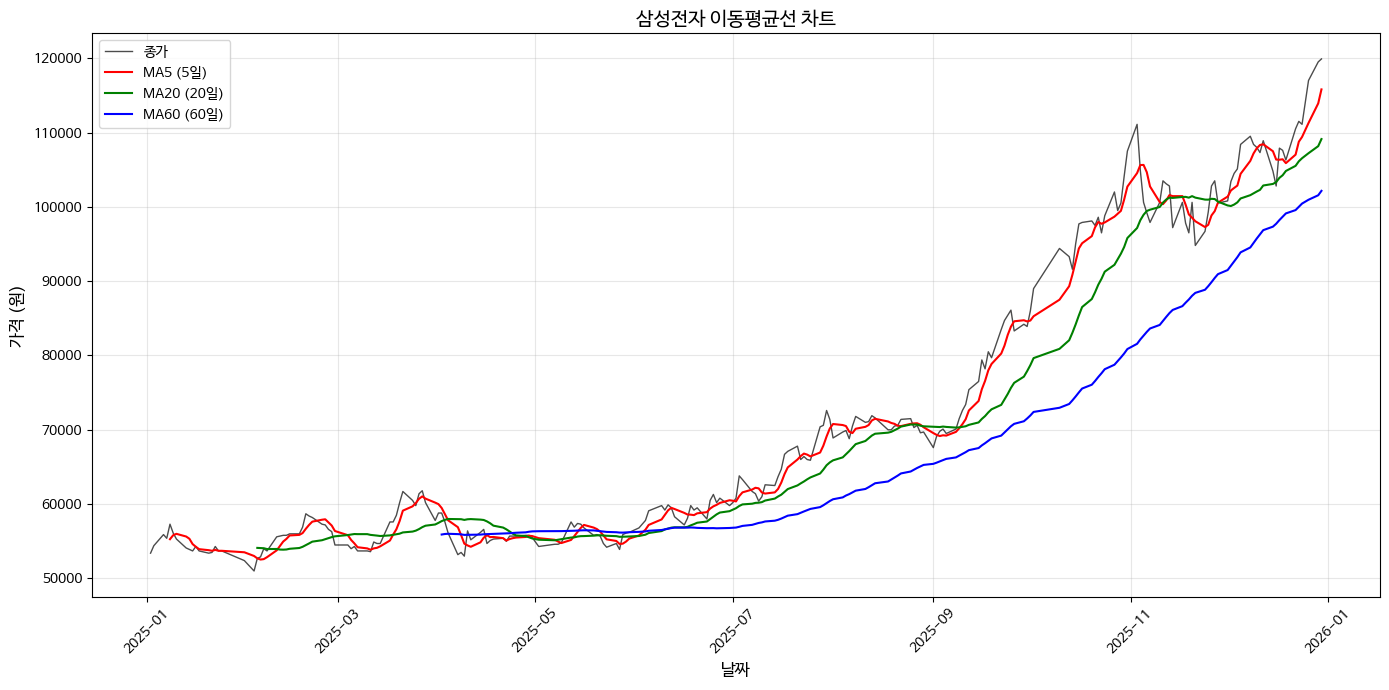

[이동평균선 해석]
  - 종가가 이동평균선 위: 상승 추세
  - 종가가 이동평균선 아래: 하락 추세
  - 정배열 (MA5 > MA20 > MA60): 강한 상승 추세
  - 역배열 (MA5 < MA20 < MA60): 강한 하락 추세


In [5]:
# 이동평균선 시각화
print("[이동평균선 시각화]")
print("=" * 60)

plt.figure(figsize=(14, 7))

# 종가와 이동평균선
plt.plot(df.index, df['종가'], color='black', linewidth=1, alpha=0.7, label='종가')
plt.plot(df.index, df['MA5'], color='red', linewidth=1.5, label='MA5 (5일)')
plt.plot(df.index, df['MA20'], color='green', linewidth=1.5, label='MA20 (20일)')
plt.plot(df.index, df['MA60'], color='blue', linewidth=1.5, label='MA60 (60일)')

plt.title(f'{stock_name} 이동평균선 차트', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('가격 (원)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("[이동평균선 해석]")
print("  - 종가가 이동평균선 위: 상승 추세")
print("  - 종가가 이동평균선 아래: 하락 추세")
print("  - 정배열 (MA5 > MA20 > MA60): 강한 상승 추세")
print("  - 역배열 (MA5 < MA20 < MA60): 강한 하락 추세")

[복합 차트: 종가 + 거래량 + 이동평균]


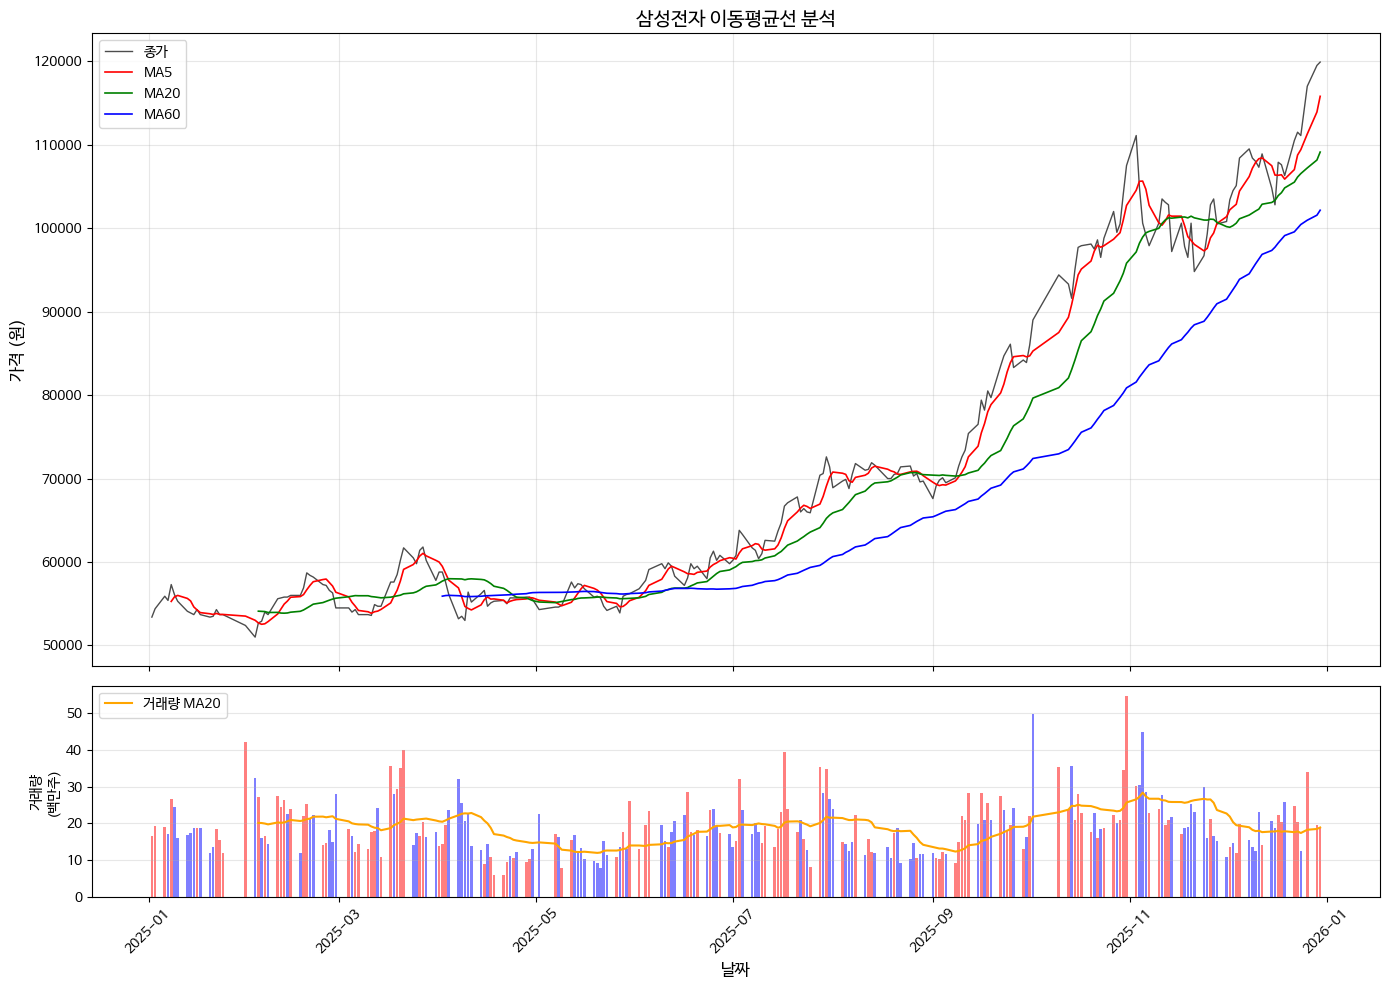

[거래량 이동평균 활용]
  - 거래량 > 거래량 MA: 평균보다 활발한 거래
  - 거래량 급증 + 가격 상승: 강한 매수세
  - 거래량 급증 + 가격 하락: 강한 매도세


In [6]:
# 종가 + 거래량 + 이동평균 복합 차트
print("[복합 차트: 종가 + 거래량 + 이동평균]")
print("=" * 60)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10),
                               gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# 상단: 종가 + 이동평균
ax1.plot(df.index, df['종가'], color='black', linewidth=1, alpha=0.7, label='종가')
ax1.plot(df.index, df['MA5'], color='red', linewidth=1.2, label='MA5')
ax1.plot(df.index, df['MA20'], color='green', linewidth=1.2, label='MA20')
ax1.plot(df.index, df['MA60'], color='blue', linewidth=1.2, label='MA60')
ax1.set_title(f'{stock_name} 이동평균선 분석', fontsize=14, fontweight='bold')
ax1.set_ylabel('가격 (원)', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 하단: 거래량 + 거래량 이동평균
df['Vol_MA20'] = df['거래량'].rolling(window=20).mean()
colors = ['red' if df.iloc[i]['종가'] >= df.iloc[i]['시가'] else 'blue' for i in range(len(df))]
ax2.bar(df.index, df['거래량'] / 1_000_000, color=colors, alpha=0.5, width=0.8)
ax2.plot(df.index, df['Vol_MA20'] / 1_000_000, color='orange', linewidth=1.5, label='거래량 MA20')
ax2.set_ylabel('거래량\n(백만주)', fontsize=10)
ax2.set_xlabel('날짜', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(axis='y', alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("[거래량 이동평균 활용]")
print("  - 거래량 > 거래량 MA: 평균보다 활발한 거래")
print("  - 거래량 급증 + 가격 상승: 강한 매수세")
print("  - 거래량 급증 + 가격 하락: 강한 매도세")

---
## 4. 지수 이동평균(EMA)

### SMA vs EMA
| 구분 | SMA (단순) | EMA (지수) |
|------|-----|-----|
| 가중치 | 모든 값에 동일 | 최근 값에 더 높은 가중치 |
| 반응 속도 | 느림 | 빠름 |
| 노이즈 | 적음 | 상대적으로 많음 |
| 용도 | 장기 추세 확인 | 단기 매매 신호 |

### Pandas 함수
```python
df['종가'].ewm(span=n).mean()
```

[SMA vs EMA 비교]


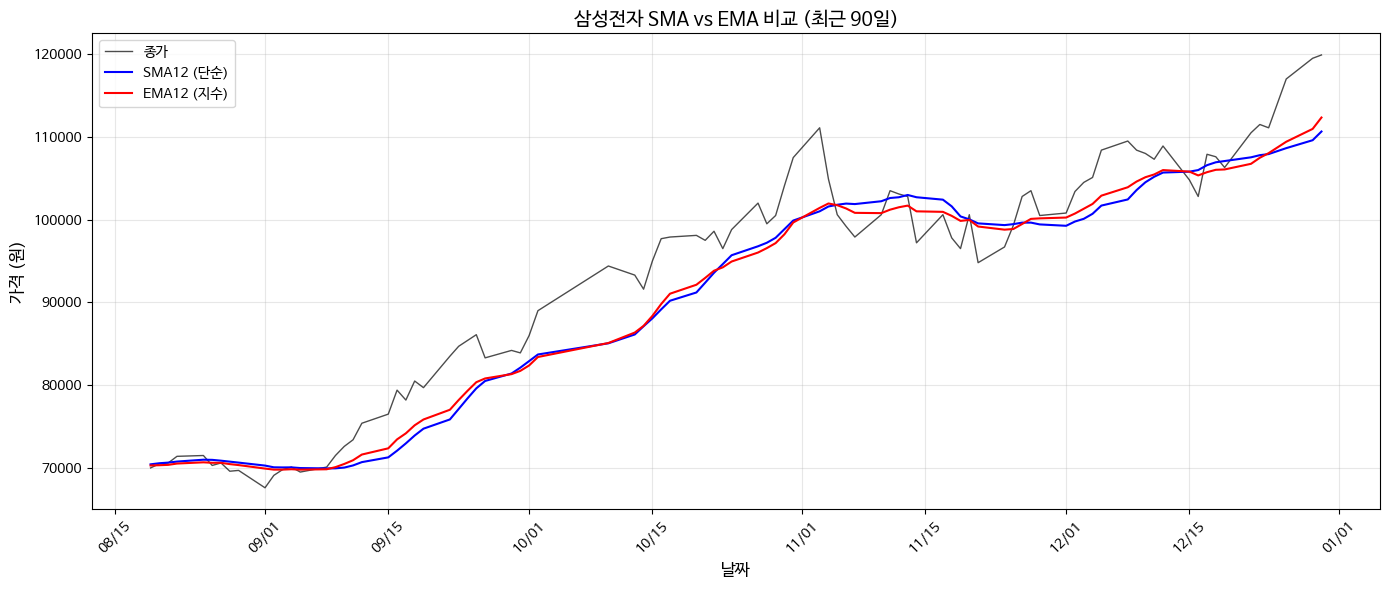

[SMA vs EMA 차이점]
  - EMA가 SMA보다 가격 변화에 빠르게 반응
  - 급등/급락 시 EMA가 더 빨리 방향 전환
  - 단기 매매: EMA 활용
  - 추세 확인: SMA 활용


In [7]:
# SMA vs EMA 비교
print("[SMA vs EMA 비교]")
print("=" * 60)

# 12일 SMA와 EMA 계산
df['SMA12'] = df['종가'].rolling(window=12).mean()
df['EMA12'] = df['종가'].ewm(span=12).mean()

# 최근 90일 데이터로 시각화
df_recent = df.tail(90)

plt.figure(figsize=(14, 6))
plt.plot(df_recent.index, df_recent['종가'], color='black', linewidth=1, alpha=0.7, label='종가')
plt.plot(df_recent.index, df_recent['SMA12'], color='blue', linewidth=1.5, label='SMA12 (단순)')
plt.plot(df_recent.index, df_recent['EMA12'], color='red', linewidth=1.5, label='EMA12 (지수)')

plt.title(f'{stock_name} SMA vs EMA 비교 (최근 90일)', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('가격 (원)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("[SMA vs EMA 차이점]")
print("  - EMA가 SMA보다 가격 변화에 빠르게 반응")
print("  - 급등/급락 시 EMA가 더 빨리 방향 전환")
print("  - 단기 매매: EMA 활용")
print("  - 추세 확인: SMA 활용")

---
## 5. 골든크로스 / 데드크로스

### 정의
| 신호 | 조건 | 의미 |
|------|------|------|
| **골든크로스** | 단기MA가 중기MA를 **상향 돌파** | 매수 신호 |
| **데드크로스** | 단기MA가 중기MA를 **하향 돌파** | 매도 신호 |

### 주의사항
- **후행성 지표**: 이미 추세가 시작된 후 신호 발생
- **횡보장 주의**: 잦은 신호로 인한 whipsaw(속임수) 가능
- 다른 지표와 함께 활용 권장

In [8]:
# 골든크로스/데드크로스 탐지
print("[골든크로스 / 데드크로스 탐지]")
print("=" * 60)

# 단기(10일), 중기(50일) 이동평균
df['MA_SHORT'] = df['종가'].rolling(window=10).mean()   # 단기 MA
df['MA_LONG'] = df['종가'].rolling(window=50).mean()    # 중기 MA

# 크로스 신호 탐지
# Signal: 1 = 단기MA > 중기MA, 0 = 단기MA <= 중기MA
df['Signal'] = 0
df.loc[df['MA_SHORT'] > df['MA_LONG'], 'Signal'] = 1

# 신호 변화 지점 찾기 (크로스 발생 시점)
df['Cross'] = df['Signal'].diff()

# 골든크로스: Signal이 0 -> 1로 변할 때 (diff = 1)
golden_cross = df[df['Cross'] == 1]

# 데드크로스: Signal이 1 -> 0으로 변할 때 (diff = -1)
dead_cross = df[df['Cross'] == -1]

print(f"분석 기간: {df.index[0].strftime('%Y-%m-%d')} ~ {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\n골든크로스 발생: {len(golden_cross)}회")
for date in golden_cross.index:
    print(f"  - {date.strftime('%Y-%m-%d')}")

print(f"\n데드크로스 발생: {len(dead_cross)}회")
for date in dead_cross.index:
    print(f"  - {date.strftime('%Y-%m-%d')}")

[골든크로스 / 데드크로스 탐지]
분석 기간: 2025-01-02 ~ 2025-12-30

골든크로스 발생: 2회
  - 2025-03-19
  - 2025-06-09

데드크로스 발생: 1회
  - 2025-04-11



[골든크로스 / 데드크로스 시각화]


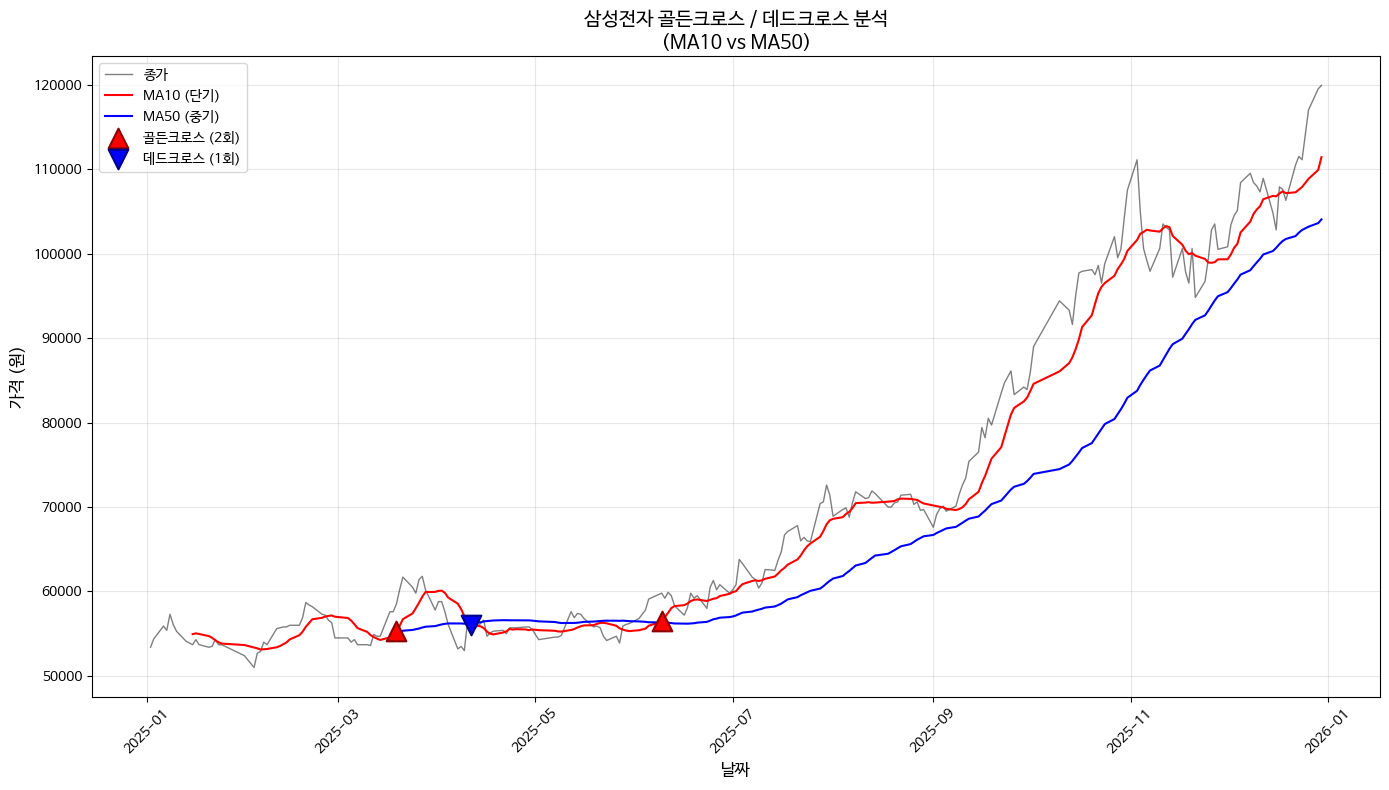

[차트 해석]
  - 빨간 삼각형 (골든크로스): 단기MA가 중기MA를 상향 돌파 -> 매수 고려
  - 파란 역삼각형 (데드크로스): 단기MA가 중기MA를 하향 돌파 -> 매도 고려

[주의사항]
  - 이동평균은 후행성 지표 (추세 확인 후 신호 발생)
  - 횡보장에서는 잦은 신호로 손실 가능
  - 거래량, 다른 지표와 함께 활용 권장


In [9]:
# 골든크로스/데드크로스 시각화
print("\n[골든크로스 / 데드크로스 시각화]")
print("=" * 60)

plt.figure(figsize=(14, 8))

# 종가 + 이동평균선
plt.plot(df.index, df['종가'], color='black', linewidth=1, alpha=0.5, label='종가')
plt.plot(df.index, df['MA_SHORT'], color='red', linewidth=1.5, label='MA10 (단기)')
plt.plot(df.index, df['MA_LONG'], color='blue', linewidth=1.5, label='MA50 (중기)')

# 골든크로스: 빨간 삼각형 (위쪽)
plt.scatter(golden_cross.index, golden_cross['MA_SHORT'],
            color='red', s=200, marker='^', zorder=5,
            edgecolors='darkred', linewidths=1.5,
            label=f'골든크로스 ({len(golden_cross)}회)')

# 데드크로스: 파란 역삼각형 (아래쪽)
plt.scatter(dead_cross.index, dead_cross['MA_SHORT'],
            color='blue', s=200, marker='v', zorder=5,
            edgecolors='darkblue', linewidths=1.5,
            label=f'데드크로스 ({len(dead_cross)}회)')

plt.title(f'{stock_name} 골든크로스 / 데드크로스 분석\n(MA10 vs MA50)', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('가격 (원)', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("[차트 해석]")
print("  - 빨간 삼각형 (골든크로스): 단기MA가 중기MA를 상향 돌파 -> 매수 고려")
print("  - 파란 역삼각형 (데드크로스): 단기MA가 중기MA를 하향 돌파 -> 매도 고려")
print("\n[주의사항]")
print("  - 이동평균은 후행성 지표 (추세 확인 후 신호 발생)")
print("  - 횡보장에서는 잦은 신호로 손실 가능")
print("  - 거래량, 다른 지표와 함께 활용 권장")

---
## 학습 정리

### 1. 이동평균 계산
- **SMA (단순)**: `df['종가'].rolling(n).mean()`
- **EMA (지수)**: `df['종가'].ewm(span=n).mean()`

### 2. 이동평균 기간
| 기간 | 용도 |
|------|------|
| 5일, 10일 | 단기 추세, 매매 타이밍 |
| 20일 | 중기 추세 (약 1개월) |
| 60일, 120일 | 장기 추세 |

### 3. 이동평균 배열
- **정배열**: MA5 > MA20 > MA60 (상승 추세)
- **역배열**: MA5 < MA20 < MA60 (하락 추세)

### 4. 크로스 신호
| 신호 | 조건 | 의미 |
|------|------|------|
| 골든크로스 | 단기MA > 중기MA 돌파 | 매수 신호 |
| 데드크로스 | 단기MA < 중기MA 돌파 | 매도 신호 |

### 5. 주의사항
- 이동평균은 **후행성 지표**
- 횡보장에서는 **whipsaw(속임수)** 주의
- 다른 지표와 **함께 활용** 권장

---

### 다음 차시 예고
- 10차시: 종합 실습 - 국내 주식 포트폴리오 분석